# Import Libraries

In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
import matplotlib.pyplot as plt

In [166]:
np.random.seed(42)

# Load Data

In [167]:
surveydata = pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/surveydata.csv',
                        low_memory = False)

# Clean Data

In [168]:
#Replace blanks and spaces with NaN
surveydata.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [169]:

replacements = {
    'CENSUS_TRK':0,
    'AGE': surveydata['AGE'].median(),
    'CNS_MEDINC': surveydata['CNS_MEDINC'].mode()[0],
    'CNSUS_PCTA': surveydata['CNSUS_PCTA'].median(),
    'CNSUS_PCTB':surveydata['CNSUS_PCTB'].median(),
    'CNSUS_PCTH':surveydata['CNSUS_PCTH'].median(),
    'CNSUS_PCTI':surveydata['CNSUS_PCTI'].median(),
    'CNSUS_PCTM':surveydata['CNSUS_PCTM'].median(),
    'CNSUS_PCTO':surveydata['CNSUS_PCTO'].median(),
    'CNSUS_PCTP':surveydata['CNSUS_PCTP'].median(), 
    'CNSUS_PCTW':surveydata['CNSUS_PCTW'].median(), 
    'CONG_DIST': '000',
    'COUNTY_TYPE': 'UNK',
    'COUNTY_ST': '000',
    'CREDRATE':'UNK',
    'DON_POLIT': 'N',
    'DON_POLCONS':'N',
    'DON_POLLIB':'N',
    'FUND_POLIT':'N',
    'DON_CHARIT':'N',
    'DON_RELIG':'N',
    'DON_HEALTH':'N',
    'DON_ANML':'N',
    'DON_ARTCUL':'N',
    'DON_CHILD':'N',
    'DON_ENVIR':'N',
    'DON_ENVWLD':'N',
    'DON_INTAID':'N',
    'DON_OTHER':'N',
    'DON_VET':'N',
    'PRFL_ENVIRONMENT':'N',
    'EDUCATION': surveydata['EDUCATION'].mode()[0],
    'ETHNICCODE':'UNK',
    'ETHNIC_INFER': surveydata['ETHNIC_INFER'].mode()[0],
    'HOMEMKTVAL': surveydata['HOMEMKTVAL'].mode()[0],
    'HOMEOWNRNT':surveydata['HOMEOWNRNT'].mode()[0],
    'INCOMESTHH':surveydata['INCOMESTHH'].mode()[0],
    'LIFESTAGE_CLUSTER':'UNK',
    'LANGUAGE':'UNK',
    'NETWORTH':surveydata['NETWORTH'].mode()[0],
    'PRESENCHLD':'N',
    'PRFL_VETERAN':'N',
    'PRFL_2NDAMEND':'N',
    'PRFL_BIDEN_SUPPORT':'N',
    'PRFL_BORDER_SECURITY':'N',
    'PRFL_EVANGELICAL':'N',
    'PRFL_IMMIGRATION_REFORM':'N',
    'PRFL_POLITICAL_IDEOLOGY':'UNK',
    'PRFL_TRUMP_SUPPORT':'N',
    'PRFL_FENCE_SITTER':'N',
    'PRFL_PERSUADABLE_VOTER':'N',
    'PRFL_MARRIAGE_EQUALITY':0,
    'PRFL_METOO_SUPPORT':'N',
    'PRFL_MIL_SUPPORT':'N',
    'PRFL_LGBT_SUPPORT':'0',
    'PRFL_MINWAGE':0,
    'PRFL_CHOICELIFE':0,
    'PRFL_LIBERAL_NEWS':'N',
    'PRFL_CONSERVATIVE_NEWS':'N',
    'RELIGION':surveydata['RELIGION'].mode()[0],
    'SEX':'UNK',
    'ST_LO_HOUS':'000',
    'ST_UP_HOUS':'00',
    'TOD_PRES_D_2016': surveydata['TOD_PRES_D_2016'].median(),
    'TOD_PRES_D_2016_PREC': surveydata['TOD_PRES_D_2016_PREC'].median(),
    'TOD_PRES_D_2020_PREC' : surveydata['TOD_PRES_D_2020_PREC'].median(),
    'TOD_PRES_O_2016' : surveydata['TOD_PRES_O_2016'].median(),
    'TOD_PRES_O_2016_PREC': surveydata['TOD_PRES_O_2016_PREC'].median(),
    'TOD_PRES_O_2020_PREC': surveydata['TOD_PRES_O_2020_PREC'].median(),
    'TOD_PRES_R_2016' : surveydata['TOD_PRES_R_2016'].median(),
    'TOD_PRES_R_2016_PREC': surveydata['TOD_PRES_R_2016_PREC'].median(),
    'TOD_PRES_R_2020_PREC': surveydata['TOD_PRES_R_2020_PREC'].median(),
    'VTR_GEN22':'N',
    'CHRISTFAM':'N',
    'ZIP': '-9999',
    'GENERATION':'UNK',
    'VTR_PPP20':'N',
    'VTR_PPP16':'N',
    'VTR_PPP12':'N',
    'VTR_PPP08':'N',
    'VTR_PRI20':'N',
    'VTR_PRI16':'N',
    'VTR_PRI12':'N',
    'VTR_PRI08':'N',

}

# Fill NaNs
for col, value in replacements.items():
    surveydata[col].fillna(value, inplace=True)

In [170]:
#clean up party (fix some inaccurate values)
surveydata.loc[(surveydata['STATE'].isin(['LA', 'DC', 'RI'])) & (surveydata['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
surveydata.loc[(surveydata['STATE'] == 'OK') & (surveydata['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

#update all non R,D/inferred, N/U to O
surveydata.loc[~surveydata['PARTY_CODE'].isin(['R', 'D', 'E', 'S', 'N', 'U']), 'PARTY_CODE'] = 'O'

# Feature Engineering

In [171]:
#feature engineering

# Create a dictionary to hold new columns
new_columns = {}

# R_donor
new_columns['R_DONOR'] = ((surveydata['FUND_POLIT'] == 'R') | (surveydata['DON_POLCONS'] == 'Y')).astype(int)

# D_donor
new_columns['D_DONOR'] = ((surveydata['FUND_POLIT'] == 'D') | (surveydata['DON_POLLIB'] == 'Y')).astype(int)

# Voted_R_Election
vtr_columns_r = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_r = surveydata[vtr_columns_r].isin(['R', 'P', 'X']).sum(axis=1)
new_columns['VOTED_R_ELECTION'] = condition_r.astype(int)

# Voted_D_Election
vtr_columns_d = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_d = surveydata[vtr_columns_d].isin(['D', 'M', 'Z']).sum(axis=1)
new_columns['VOTED_D_ELECTION'] = condition_d

# add a feature for number of absentee votes
vtr_columns = [col for col in surveydata.columns if col.startswith('VTR_')]
new_columns['ABSENTEE_VOTES'] = surveydata[vtr_columns].apply(lambda row: sum(row.isin(['A', 'X', 'Z'])), axis=1)

# add a feature for number of primary votes
vtr_p_columns = [col for col in surveydata.columns if col.startswith('VTR_P')]
new_columns['NUM_PRIMARY_VOTES'] = surveydata[vtr_p_columns].apply(lambda row: sum(row.isin(['A','X','Z','D','R','M','P','E','Y'])), axis=1)

# additional features
new_columns['ABS_2022'] = (surveydata['VTR_GEN22'] == 'A').astype(int)
new_columns['ENGLISH_SPEAKER'] = (surveydata['LANGUAGE'] == 'E1').astype(int)

new_columns['ABS_2016'] = (surveydata['VTR_GEN16'] == 'A').astype(int)


new_columns['PRES_2020_D_WINNER'] = (surveydata['TOD_PRES_DIFF_2020_PREC'].str[-1] == 'D').astype(int)
new_columns['PRES_2020_R_WINNER'] = (surveydata['TOD_PRES_DIFF_2020_PREC'].str[-1] == 'R').astype(int)

new_columns['PRES_2016_D_WINNER'] = (surveydata['TOD_PRES_DIFF_2016_PREC'].str[-1] == 'D').astype(int)
new_columns['PRES_2016_R_WINNER'] = (surveydata['TOD_PRES_DIFF_2016_PREC'].str[-1] == 'R').astype(int)


# Update surveydata with new columns
surveydata = pd.concat([surveydata, pd.DataFrame(new_columns)], axis=1)

# After all operations, create a fresh copy to de-fragment the dataframe
surveydata = surveydata.copy()


In [172]:
#try to infer party for records we have N or U values

def set_inferred_party(row):
    not_in_list = ['D', 'R', 'M', 'P', 'X', 'Z']
    rpx = ['R', 'P', 'X']
    dmz = ['D', 'M', 'Z']

    if row['PARTY_CODE'] in ['N', 'U']:
        if (
            (row['FUND_POLIT'] == 'R' or row['DON_POLCONS'] or row['PRFL_HEALTHCARE_REFORM'] == '2' or 
            row['PRFL_2NDAMEND'] == 'Y' or row['PRFL_CHOICELIFE'] == '1') and row['FUND_POLIT'] != 'D' and 
            not row['DON_POLLIB'] and all(row[col] not in not_in_list for col in 
            ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]])
        ) or (
            sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] 
            if row[col] in rpx) > sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
            ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
        ):
            return 'S'
        elif (
            (row['FUND_POLIT'] == 'D' or row['DON_POLLIB'] or row['PRFL_HEALTHCARE_REFORM'] == '1' or 
            row['PRFL_CHOICELIFE'] == '2') and row['FUND_POLIT'] != 'r' and not row['DON_POLCONS'] and 
            all(row[col] not in not_in_list for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
            ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]])
        ) or (
            sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] 
            if row[col] in rpx) < sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
            ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
        ):
            return 'E'
    return row['PARTY_CODE']  # Return original value if no conditions are met

# Apply the function
surveydata['PARTY_INFER'] = surveydata.apply(set_inferred_party, axis=1)



In [173]:



def feature_engineering_voting_data(survey_df, interaction_type='cat'):

    # Define the vote types
    democrat_votes = ['D', 'M', 'Z']
    republican_votes = ['R', 'P', 'X']
    early_votes = ['E', 'M', 'P']
    absentee_votes = ['A', 'Z', 'X']
    

    survey_df['interaction_div_2020'] = survey_df['CNSUS_PCTW'] / survey_df['TOD_PRES_R_2020_PREC']
 
    survey_df['interaction_div_2016'] = survey_df['CNSUS_PCTW'] / survey_df['TOD_PRES_R_2016_PREC']

    # Delta interaction term
    survey_df['interaction_mult_delta'] = (survey_df['TOD_PRES_R_2020_PREC'] - survey_df['TOD_PRES_R_2016_PREC']) * survey_df['CNSUS_PCTW']


    # Interaction terms for 2020 with respect to Democratic turnout
    survey_df['interaction_div_D_2020'] = survey_df['CNSUS_PCTB'] / survey_df['TOD_PRES_D_2020_PREC']

    survey_df['interaction_div_D_2016'] = survey_df['CNSUS_PCTB'] / survey_df['TOD_PRES_D_2016_PREC']

    # Delta interaction term for Democratic turnout
    survey_df['interaction_mult_D_delta'] = (survey_df['TOD_PRES_D_2020_PREC'] - survey_df['TOD_PRES_D_2016_PREC']) * survey_df['CNSUS_PCTB']

    survey_df['Years_Voted_Democrat'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['D', 'M', 'Z'])), axis=1)
    survey_df['Years_Voted_Republican'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['R', 'P', 'X'])), axis=1)

    survey_df['Years_Absentee_Democrat'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['Z'])), axis=1)
    survey_df['Years_Early_Democrat'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['M'])), axis=1)
    survey_df['Years_Absentee_Republican'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['X'])), axis=1)
    survey_df['Years_Early_Republican'] = survey_df[['VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20']].apply(lambda x: sum(x.isin(['P'])), axis=1)

    # function to count specific vote types
    def count_votes(vote_counts, vote_types):
        return sum(vote_counts.get(vote_type, 0) for vote_type in vote_types)

    # function to count longest streak for a party
    def longest_streak(votes, party_votes):
        streaks = [sum(1 for _ in g) for k, g in groupby(votes) if k in party_votes]
        return max(streaks) if streaks else 0

    # count early and absentee votes
    survey_df['count_Early'] = survey_df.filter(like='VTR_').apply(lambda row: count_votes(row.value_counts(), early_votes), axis=1)
    survey_df['count_Absentee'] = survey_df.filter(like='VTR_').apply(lambda row: count_votes(row.value_counts(), absentee_votes), axis=1)
    survey_df['total_votes'] = survey_df.filter(like='VTR_').apply(lambda row: sum((row != 'N') & (row.notna())), axis=1)

    
    return survey_df

feature_engineering_voting_data(surveydata)


,RECORD_ID,ADD_TYPE,AFAMPROFLS,AGE,AI_COUNTY_NAME,AIRCOND,APP_CHILD,APP_MENBIG,APP_TODDLR,APP_WOMEN,...,interaction_mult_D_delta,Years_Voted_Democrat,Years_Voted_Republican,Years_Absentee_Democrat,Years_Early_Democrat,Years_Absentee_Republican,Years_Early_Republican,count_Early,count_Absentee,total_votes
0,100544,S,NaN,63.0,MARION,NaN,NaN,NaN,NaN,NaN,...,203.392858,3,1,1,0,0,0,0,4,16
1,100886,S,NaN,73.0,POLK,A,NaN,NaN,NaN,NaN,...,28.571429,0,0,0,0,0,0,5,0,25
2,101569,S,NaN,86.0,LOS ANGELES,A,NaN,NaN,NaN,NaN,...,-0.000000,0,0,0,0,0,0,0,12,24
3,101672,S,NaN,55.0,OCEAN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0,0,0,0,0,0,0,1,20
4,101908,S,NaN,73.0,JEFFERSON,NaN,NaN,NaN,NaN,NaN,...,49.859154,0,0,0,0,0,0,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,99038,S,NaN,50.0,TOMPKINS,NaN,NaN,NaN,NaN,NaN,...,-0.000000,0,0,0,0,0,0,0,0,19
1556,99209,S,NaN,80.0,DANE,NaN,NaN,NaN,NaN,NaN,...,2.105261,0,0,0,0,0,0,0,5,25
1557,99271,S,NaN,54.0,HILLSBOROUGH,NaN,NaN,NaN,NaN,NaN,...,0.000000,0,0,0,0,0,0,0,0,20
1558,99511,S,NaN,57.0,POLK,NaN,NaN,NaN,NaN,NaN,...,-80.000000,0,0,0,0,0,0,0,3,26


In [174]:
surveydata['Q1_Candidate'].value_counts()

President Donald Trump            493
President Joe Biden               492
Governor Ron DeSantis             117
Undecided                          98
Nikki Haley                        82
Robert F. Kennedy Jr.              56
Vice-President Mike Pence          47
Governor Chris Christie            42
Other - Write In                   34
Vivek Ramaswamy                    34
Senator Tim Scott                  32
Marianne Williamson                16
Governor Gavin Newsom               7
Governor Doug Burgum                4
Former Governor Asa Hutchinson      2
Former Congressman Will Hurd        2
Mayor Francis Suarez                1
Larry Elder                         1
Name: Q1_Candidate, dtype: int64

In [175]:
#consolidate target column of interest

candidates_to_replace1 = [
    "Governor Doug Burgum",
    "Former Governor Asa Hutchinson",
    "Former Congressman Will Hurd",
    "Larry Elder",
    "Mayor Francis Suarez",
    "Governor Ron DeSantis",
    "Nikki Haley",
    "Vice-President Mike Pence",
    "Governor Chris Christie",
    "Vivek Ramaswamy",
    "Senator Tim Scott"]

# Replacing the specified values with "Other GOP"
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace1, "Other GOP")

candidates_to_replace2 = ["Robert F. Kennedy Jr.", "Marianne Williamson", "Governor Gavin Newsom"]
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace2, "Other DEM")

candidates_to_replace3 =["Other - Write In", "Undecided"]

surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace3, "Other/Undecided")

#lets drop the 2 smallest categories and see if performance on the top 3 improves
surveydata = surveydata[~surveydata['Q1_Candidate'].isin(['Other/Undecided', 'Other DEM'])]

surveydata['Q1_Candidate'].value_counts()

President Donald Trump    493
President Joe Biden       492
Other GOP                 364
Name: Q1_Candidate, dtype: int64

In [176]:

columns_to_use = ['AGE', 
                  'CNS_MEDINC', 
                  'CNSUS_PCTA', 
                  'CNSUS_PCTB',
                  'CNSUS_PCTH', 
                  'CNSUS_PCTI', 
                  'CNSUS_PCTM', 
                  'CNSUS_PCTO', 
                  'CNSUS_PCTP', 
                  'CNSUS_PCTW',
                  'COUNTY_TYPE', 
                  'DON_POLIT', 
                  'EDUCATION', 
                  'ETHNIC_INFER',
                  'HOMEMKTVAL', 
                  'HOMEOWNRNT', 
                  #'INCOMESTHH', 
                  'NETWORTH',
                  'PARTY_CODE', 
                  'PARTY_MIX', 
                  'PRESENCHLD', 
                  'PRFL_POLITICAL_IDEOLOGY',
                  'RELIGION', 
                  'SEX', 
                  'CENSUS_ST',  
                  'R_DONOR', 
                  'D_DONOR', 
                  'VOTED_R_ELECTION', 
                  'VOTED_D_ELECTION', 
                  'PRFL_2NDAMEND',
                  'PRFL_BIDEN_SUPPORT',
                  'PRFL_BORDER_SECURITY',
                  'PRFL_EVANGELICAL',
                  'PRFL_IMMIGRATION_REFORM',
                  'PRFL_TRUMP_SUPPORT',  
                  'DON_CHARIT',
                  'DON_RELIG',
                  'PRFL_FENCE_SITTER',
                  'PRFL_PERSUADABLE_VOTER',
                  'PRFL_LGBT_SUPPORT', 
                  'CREDRATE',
                  'ABSENTEE_VOTES',
                  'NUM_PRIMARY_VOTES',
                  'PRFL_CHOICELIFE', 
                  'PRFL_ENVIRONMENT',
                  'PRFL_MARRIAGE_EQUALITY',
                  'PRFL_METOO_SUPPORT',
                  'PRFL_MIL_SUPPORT',
                  'PRFL_MINWAGE', 
                  'PRFL_CONSERVATIVE_NEWS',
                  'PRFL_LIBERAL_NEWS',
                  'DON_HEALTH',
                  'ABS_2022',
                  'ENGLISH_SPEAKER',
                  'Q1_Candidate',
                  'DON_ANML',
                  'PRES_2020_D_WINNER',
                  'PRES_2020_R_WINNER', 
                  'PRES_2016_D_WINNER',
                  'PRES_2016_R_WINNER',
                  'ABS_2016',
                  'CHRISTFAM',
                  'GENERATION',
                  'PARTY_INFER',
                  'VTR_PPP20', 
                  'VTR_PPP16',
                  'VTR_PPP12']

columns_to_use.extend(['Years_Voted_Democrat'])
#columns_to_use.extend(['Years_Voted_Republican'])
columns_to_use.extend(['interaction_div_2020'])
columns_to_use.extend(['interaction_div_2016'])  
columns_to_use.extend(['interaction_mult_delta'])                                    
#columns_to_use.extend(['Years_Absentee_Democrat']) 
#columns_to_use.extend(['Years_Early_Democrat']) 
columns_to_use.extend(['Years_Absentee_Republican']) 
columns_to_use.extend(['Years_Early_Republican'])

#columns_to_use.append('total_votes')
                      
surveydata = surveydata[columns_to_use]

In [177]:
#BEST_COLUMNS = columns_to_use

In [178]:
columns_to_use

['AGE',
 'CNS_MEDINC',
 'CNSUS_PCTA',
 'CNSUS_PCTB',
 'CNSUS_PCTH',
 'CNSUS_PCTI',
 'CNSUS_PCTM',
 'CNSUS_PCTO',
 'CNSUS_PCTP',
 'CNSUS_PCTW',
 'COUNTY_TYPE',
 'DON_POLIT',
 'EDUCATION',
 'ETHNIC_INFER',
 'HOMEMKTVAL',
 'HOMEOWNRNT',
 'NETWORTH',
 'PARTY_CODE',
 'PARTY_MIX',
 'PRESENCHLD',
 'PRFL_POLITICAL_IDEOLOGY',
 'RELIGION',
 'SEX',
 'CENSUS_ST',
 'R_DONOR',
 'D_DONOR',
 'VOTED_R_ELECTION',
 'VOTED_D_ELECTION',
 'PRFL_2NDAMEND',
 'PRFL_BIDEN_SUPPORT',
 'PRFL_BORDER_SECURITY',
 'PRFL_EVANGELICAL',
 'PRFL_IMMIGRATION_REFORM',
 'PRFL_TRUMP_SUPPORT',
 'DON_CHARIT',
 'DON_RELIG',
 'PRFL_FENCE_SITTER',
 'PRFL_PERSUADABLE_VOTER',
 'PRFL_LGBT_SUPPORT',
 'CREDRATE',
 'ABSENTEE_VOTES',
 'NUM_PRIMARY_VOTES',
 'PRFL_CHOICELIFE',
 'PRFL_ENVIRONMENT',
 'PRFL_MARRIAGE_EQUALITY',
 'PRFL_METOO_SUPPORT',
 'PRFL_MIL_SUPPORT',
 'PRFL_MINWAGE',
 'PRFL_CONSERVATIVE_NEWS',
 'PRFL_LIBERAL_NEWS',
 'DON_HEALTH',
 'ABS_2022',
 'ENGLISH_SPEAKER',
 'Q1_Candidate',
 'DON_ANML',
 'PRES_2020_D_WINNER',
 'PRES_20

In [179]:
surveydata.head()

,AGE,CNS_MEDINC,CNSUS_PCTA,CNSUS_PCTB,CNSUS_PCTH,CNSUS_PCTI,CNSUS_PCTM,CNSUS_PCTO,CNSUS_PCTP,CNSUS_PCTW,...,PARTY_INFER,VTR_PPP20,VTR_PPP16,VTR_PPP12,Years_Voted_Democrat,interaction_div_2020,interaction_div_2016,interaction_mult_delta,Years_Absentee_Republican,Years_Early_Republican
0,63.0,00691,0.000000,30.357143,7.142857,0.0,5.357143,0.0,0.000000,57.142857,...,E,Z,D,D,3,1.752848,1.495886,-319.999999,0,0
2,86.0,00691,24.324324,0.000000,43.243243,0.0,0.000000,0.0,0.000000,32.432432,...,D,A,A,N,0,0.614251,0.717532,246.486483,0,0
5,30.0,00691,0.000000,4.242424,7.272727,0.0,10.909091,0.0,0.606061,76.969697,...,U,N,N,N,0,1.706645,1.658830,-100.060606,0,0
6,54.0,01059,4.487179,0.000000,7.692308,0.0,0.000000,0.0,0.000000,87.820513,...,R,N,N,N,0,1.488483,1.463675,-87.820513,0,0
7,42.0,00720,5.263158,15.789474,36.842105,0.0,12.280702,0.0,0.000000,29.824561,...,R,A,N,N,0,0.522322,0.776681,557.719291,0,0


In [180]:

surveydata['CNS_MEDINC'] = surveydata['CNS_MEDINC'].astype(float)

categorical_columns = surveydata.select_dtypes(include=['object', 'category']).columns.tolist()

label_encoders = {}
for col in categorical_columns:
    # Convert all non-numeric types to string
    surveydata[col] = surveydata[col].apply(lambda x: str(x))
    le = LabelEncoder()
    surveydata[col] = le.fit_transform(surveydata[col])
    label_encoders[col] = le

# Train / Test Split

In [181]:
features_to_use = [col for col in columns_to_use if col != 'Q1_Candidate']


X = surveydata[features_to_use].copy()
y = surveydata['Q1_Candidate'].copy()

# Use stratified split for maintaining the distribution
#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
#for train_idx, test_idx in sss.split(X, y):
#    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()  # Added copy() here
#    y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

In [182]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)

# Making predictions
y_pred = gb_clf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6259259259259259
              precision    recall  f1-score   support

           0       0.57      0.35      0.43        69
           1       0.57      0.67      0.62        98
           2       0.70      0.77      0.73       103

    accuracy                           0.63       270
   macro avg       0.61      0.60      0.59       270
weighted avg       0.62      0.63      0.61       270



# Feature Importances

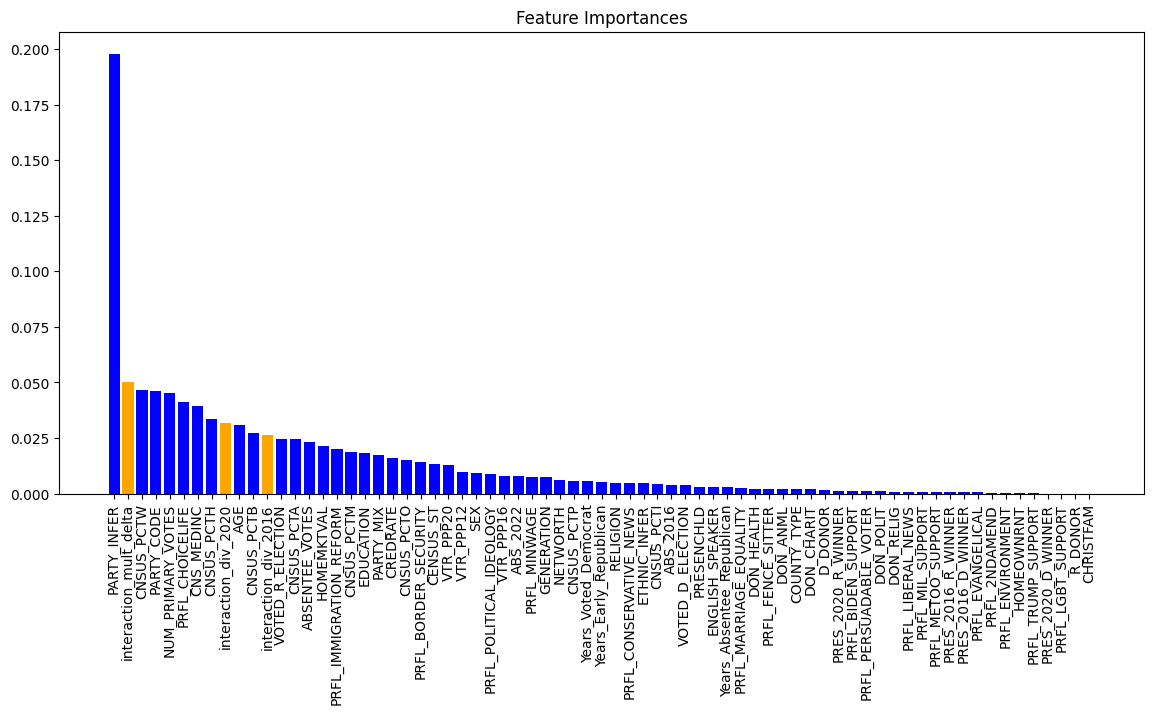

In [183]:
feature_importances = gb_clf.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(14, 6))
plt.title("Feature Importances")

# Determine the color for each bar
colors = ['orange' if feature_names[i][0].islower() else 'blue' for i in indices]

plt.bar(range(X_train.shape[1]), feature_importances[indices], color=colors)
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation='vertical')
plt.show()


# Evaluation

# Averages Across 10 Folds

In [184]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

gb_clf = GradientBoostingClassifier()

# Using StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to hold the metrics for each fold
accuracies = []
precision_list = {0: [], 1: [], 2: []}
recall_list = {0: [], 1: [], 2: []}
f1_score_list = {0: [], 1: [], 2: []}

for train_index, test_index in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    gb_clf.fit(X_train_fold, y_train_fold)
    y_pred_fold = gb_clf.predict(X_test_fold)
    
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
    
    report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    
    for label in [0, 1, 2]:
        precision_list[label].append(report[str(label)]['precision'])
        recall_list[label].append(report[str(label)]['recall'])
        f1_score_list[label].append(report[str(label)]['f1-score'])

# Compute average metrics
avg_accuracy = np.mean(accuracies)
avg_precision = {label: np.mean(precision_list[label]) for label in [0, 1, 2]}
avg_recall = {label: np.mean(recall_list[label]) for label in [0, 1, 2]}
avg_f1_score = {label: np.mean(f1_score_list[label]) for label in [0, 1, 2]}

print(f"Average Accuracy: {avg_accuracy:.2f}")
print("Average Precision per Class:", avg_precision)
print("Average Recall per Class:", avg_recall)
print("Average F1-Score per Class:", avg_f1_score)


Average Accuracy: 0.53
Average Precision per Class: {0: 0.27570230165431403, 1: 0.5010440525598304, 2: 0.6663010089867619}
Average Recall per Class: {0: 0.15655172413793103, 1: 0.627948717948718, 2: 0.7170040485829959}
Average F1-Score per Class: {0: 0.19673698480936763, 1: 0.5542081051001112, 2: 0.6874179782363028}


# Learning Curve Analysis

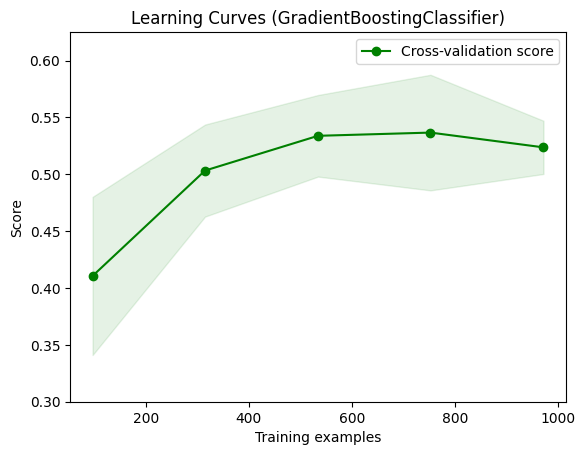

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

title = "Learning Curves (GradientBoostingClassifier)"
cv = 10  # Number of cross-validation splits
plot_learning_curve(gb_clf, title, X_train, y_train, ylim=(0.3, 0.625), cv=cv, n_jobs=4)
plt.show()



# ROC-AUC Scores

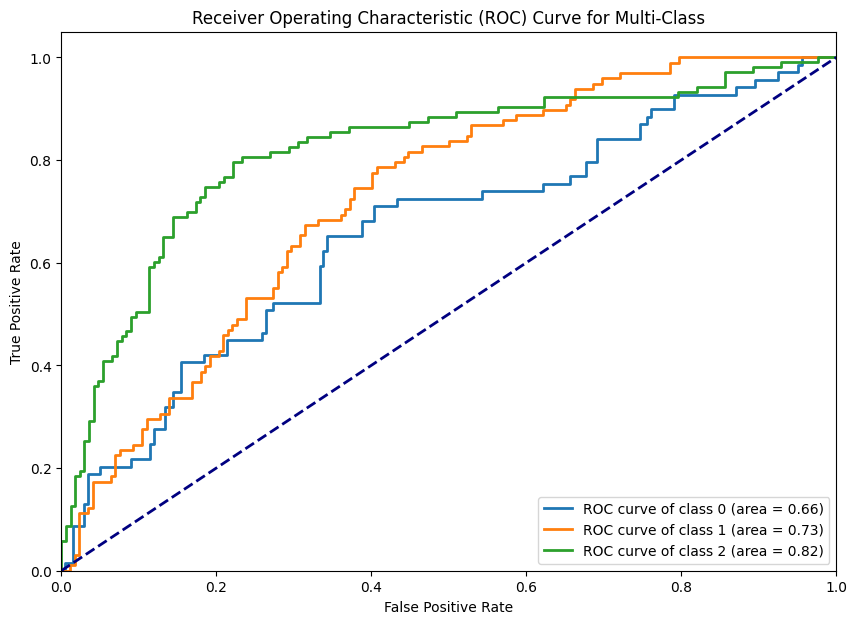

In [157]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the y_test labels for multi-class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute the probability scores
y_scores = gb_clf.predict_proba(X_test)

# Plot linewidth
lw = 2

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, lw=lw, label=f'ROC curve of class {i} (area = {roc_auc:0.2f})')

# Plot ROC for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()



In [18]:
# Save the model to a pickle file
filename = 'gbc_candidate_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gb_clf, file)